# A Traditional Machine Learning Approach to Speech Recognition
Francesco Capuano, Nov. 2021

Laboratory 7 of the Data Science Lab course, carried out in the context of the MSc in Data Science and Engineering at Politecnico di Torino, Turin, Italy.

In [1]:
# useful imports
import os
import pandas as pd
import numpy as np
from scipy.io import wavfile as wav
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import seaborn as sns

#accessing the folder in which files are stored
jup_PATH = os.getcwd()

os.chdir(jup_PATH+"/free-spoken-digit")
data_PATH = os.path.basename(os.getcwd())

os.chdir("dev")
dev_PATH = os.path.basename(os.getcwd())

audios = os.listdir()

TO_AUDIOS = jup_PATH + "/" + data_PATH + "/" + dev_PATH + "/"

The file in the *dev* folder are named after the following convention: `<speakerId>_<spokenDigit>.wav`. Considering this, in order to obtain a full informative dataset, each .wav file must be mapped to its correspondent spoken digit. The results are then stored in a pandas dataframe, as it allows many of the to operations that will follow with ease.

In [2]:
signals = pd.DataFrame()

signals["FILE"] = os.listdir(TO_AUDIOS)

readings = []
for f in signals["FILE"]:
    r = f.split(sep = ".")[0]
    r = r.split(sep = "_")[1]

    readings.append(r)

signals["NUMBERS"] = readings

Considering that the first steps of the process which terminates with model learning typically consists in preliminary trials, down-sampling the original dataframe will definitely results in faster analysis, allowing an overall more bearable decision making process, both in terms of computational resources and computational time.

The following cell down-samples the original dataframe with a parameter `FRACTION`, obviously making sure that in the sampled version of the dataframe one has all the necessary digits.

In [3]:
# here I do control the fraction of the dataset to use in the training process
# at the end of the process this fraction equals 1 so that I can use all the data
FRACTION = 1

sig_sample = signals.groupby(by = "NUMBERS").sample(frac = FRACTION)

In [4]:
# custom made normalization function to experiment around with different normalizations
def normalize(array, criteria = "min,max"):
    """
    Normalizes a given array according to a specific array. 
    -------
    Parameters:
    array: array to be normalized
    
    criteria: 
            min,max: normalizes the array with respect to minimal and maximal value
            z: normalizes the array using z-normalization
            norm_2: transform the prompted array in an unitary array
    ---------
    Returns: 
    multiple returns, basically an array.
    
    """
    if criteria == "min,max": 
        return (array - np.min(array))/(np.max(array) - np.min(array))
    
    if criteria == "z": 
        return (array - np.mean(array))/np.std(array)
    
    if criteria == "norm_2": 
        return array/np.linalg.norm(array)

## Accessing the waveforms
Each recording present in the dataset is in a .wav format. However, these formats are clearly not intelligible to traditional ML algorithms and therefore need to be converted to their correspondent numerical representation. This is basically done recalling that if $x(t)$ is a signal, then different representations of this signal are available, with respect to the different domains one could consider.

In this work, each signal has been alternatively represented in the time domain and in the frequency domain. Out of these two domains, three different representation of the same signal are stored in the dataframe to better experiment.

1) $A(t)$, that is the representation of the amplitude of the signal in the time domain

2) $A(f)$, that is the representation of the amplitude of the signal in the frequency domain. This has been obtained using the Fast Fourier Transform.

3) $\big|A(f)\big|^2$, that is the representation of $E(f)$, i.e. the energy in the frequency domain.

More than that, a common representation to the time and frequency domain has been stored in the dataframe. This representation is the *spectrogram* of the signal. This is an image (manageable as a matrix) which shows how frequency changes with respect to time in the given signal.

All these representations are obtained and stored so that the transcription of the signal is complete enough that other, future, analysis can be carried out on a fully-descripted file.

### Accessing the data
This section of code is mainly devoted to append to the *sig_sample* DataFrame a column in which the signal is presented as an array in the different domains.

In [5]:
AUDIO = []
F_AUDIO = []
EN_AUDIO = []
SPEC = []
TIME = []

for f in tqdm(sig_sample.FILE):
    # reading the audio file
    input_data = wav.read(f)
    s_rate = input_data[0]

    audio = normalize(input_data[1], criteria = "z")

    # time representation - A(t)
    AUDIO.append(audio)

    # duration of the audio
    TIME.append(len(audio)/s_rate)

    # frequency representation - A(f)
    f_audio = normalize(fft(audio), criteria = "z")
    F_AUDIO.append(f_audio)

    # frequency representation - E(f)
    en_audio = normalize(np.abs(f_audio**2), criteria="z")
    EN_AUDIO.append(en_audio)

    # time/frequency representation - Spectrogram(sig)
    SPEC.append(spectrogram(audio)[2])

sig_sample["Time Domain"] = AUDIO
sig_sample["Frequency Domain - amplitude"] = F_AUDIO
sig_sample["Frequency Domain - energy"] = EN_AUDIO
sig_sample["Spectrogram"] = SPEC
sig_sample["Time"] = TIME

# setting the file name as index - this is practical for the following evaluation steps
sig_sample.set_index("FILE", inplace = True)

100%|██████████| 1500/1500 [00:03<00:00, 398.35it/s]


Once the signals have been fully described it is possible to analyse them in statistical terms. As a preliminary example, the length of the signal is certainly important, as it may lead to discard those signals which are related to having forgotten the registration microphone on, for example.

The following cell does exactly this: checks the statistical distribution of the length of the signals.

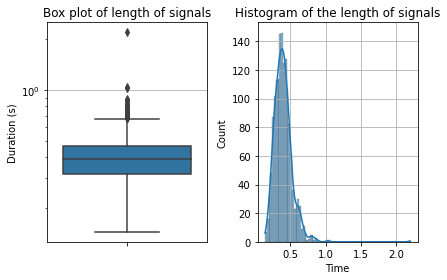

In [6]:
os.chdir(jup_PATH)
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].set_title("Box plot of length of signals")
ax[0].set_yscale("log")
ax[0].set_ylabel("Duration (s)")
ax[0].grid()

g1 = sns.boxplot(data = sig_sample.Time, ax = ax[0])
g1.set(xticklabels = [])

ax[1].set_title("Histogram of the length of signals")
sns.histplot(data = sig_sample.Time, kde = True, ax = ax[1])
ax[1].grid()

fig.tight_layout()
fig.savefig("DurationAnalysis.svg")

plt.show()

## Data cleaning
In this section the signals with a non statistical lasting are discarded in the sake of outliers detection. Outliers detection is done with basic z-score.

## Data cleaning
In this section the signals with a non statistical lasting are discarded in the sake of outliers detection. Outliers detection is done with basic z-score.

Essentially, if $\bar{x}$ and $s_x$ are the empirical mean and std. deviation of the length $x$ of each signal, then all the signals that have a length $l: l \notin \big[ \bar{x} \pm \alpha s_x \big], \alpha \in \mathbb N$ are considered outliers and, therefore, discarded.

In [7]:
# the parameter alpha fore presented
mul = 3

t_mean = np.mean(sig_sample["Time"])
t_std = np.std(sig_sample["Time"])

sig_sample = sig_sample.loc[
    (sig_sample["Time"] <= t_mean + mul * t_std) & sig_sample["Time"] >= t_mean - mul * t_std  
]

### Plotting

This section of the code basically serves as a section in which perform some exploratory technique to get to better know the data.
This is done on a subset of the data that basically permits to observe the difference among different signals.

This is done to explore whether or not the different representation of the different signals in the chosen domains are sufficiently different one between one another with respect to the related digit.
What would be ideal is large difference between different digits and small difference between the same number's recordings.

#### Energy based representation (in the frequency domain)

In [8]:
os.chdir(TO_AUDIOS)

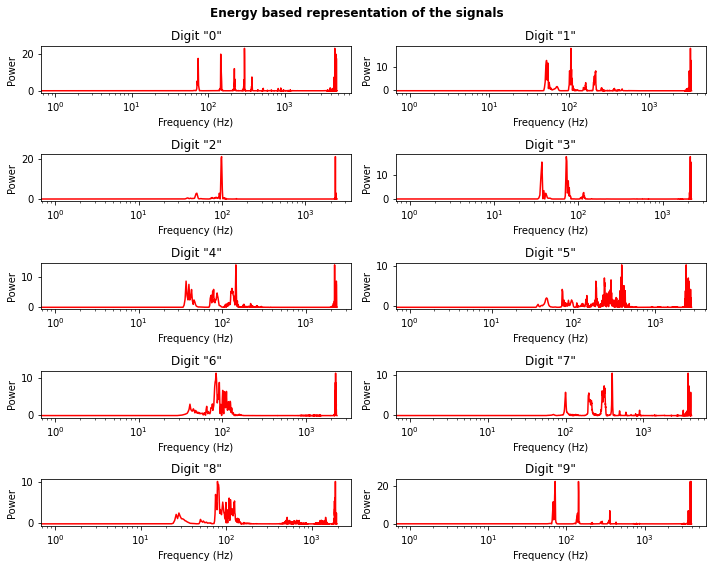

In [9]:
# a df in which are present samples of each single spoken label
unique_tracks = sig_sample.groupby(by = "NUMBERS").sample(n = 1)

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (10,8))
fig.suptitle("Energy based representation of the signals", fontweight = "bold")
idx = 0
for file in unique_tracks.index:
    number = unique_tracks.loc[file, "NUMBERS"]
    input_data = wav.read(file)
    audio = normalize(input_data[1], criteria = "z")

    f_audio = normalize(fft(audio), criteria = "z")

    en_audio = normalize(np.abs(f_audio**2), criteria="z")

    ax[idx//2, idx%2].plot(en_audio, color = "r")

    ax[idx//2, idx%2].set_xlabel("Frequency (Hz)")
    ax[idx//2, idx%2].set_ylabel("Power")
    ax[idx//2, idx%2].set_xscale("log")

    ax[idx//2, idx%2].set_title(f'Digit "{number}"')

    idx += 1

fig.tight_layout()
plt.show()

#### Amplitude based representation (in the time domain)

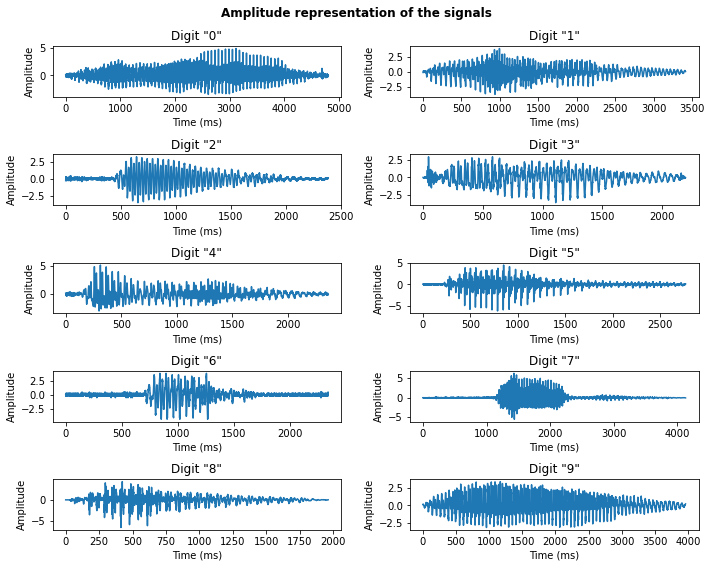

In [10]:
os.chdir(TO_AUDIOS)
fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (10,8))
fig.suptitle("Amplitude representation of the signals", fontweight = "bold")
idx = 0
for file in unique_tracks.index:
    number = unique_tracks.loc[file, "NUMBERS"]
    input_data = wav.read(file)
    audio = normalize(input_data[1], criteria = "z")

    ax[idx//2, idx%2].plot(audio)
    ax[idx//2, idx%2].set_ylabel("Amplitude")
    ax[idx//2, idx%2].set_xlabel("Time (ms)")

    ax[idx//2, idx%2].set_title(f'Digit "{number}"')

    idx += 1

fig.tight_layout()
os.chdir(jup_PATH)
fig.savefig("TimeBasedRepresentation.svg")
plt.show()

#### Spectrogram based representation (in the time/frequency domain)

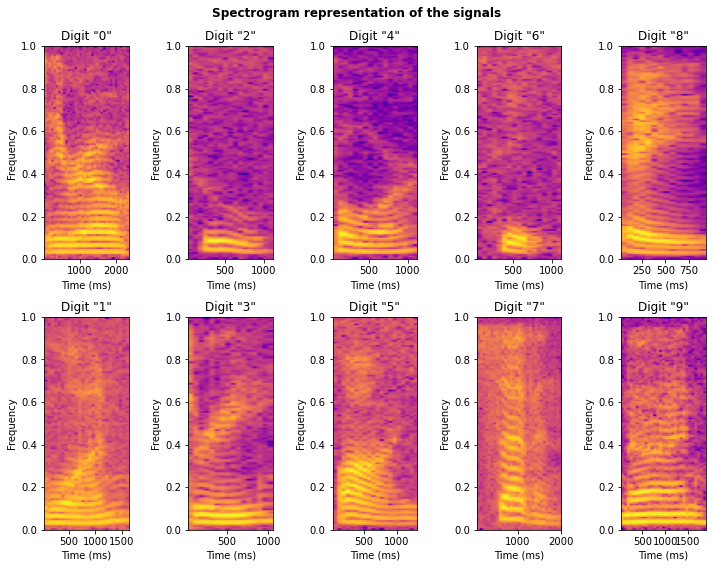

In [11]:
os.chdir(TO_AUDIOS)
fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize = (10,8))
fig.suptitle("Spectrogram representation of the signals", fontweight = "bold")
idx = 0
for file in unique_tracks.index:
    number = unique_tracks.loc[file, "NUMBERS"]
    input_data = wav.read(file)
    audio = normalize(input_data[1], criteria = "z")

    ax[idx%2, idx//2].specgram(audio, cmap = "plasma")
    ax[idx%2, idx//2].set_ylabel("Frequency")
    ax[idx%2, idx//2].set_xlabel("Time (ms)")

    ax[idx%2, idx//2].set_title(f'Digit "{number}"')

    idx += 1

fig.tight_layout()
os.chdir(jup_PATH)
fig.savefig("SpectrogramRepresentation.svg")
plt.show()

## The spectrogram

Since a spectrogram is defined as a $n \times m$ matrix defying a signal in the way it behaves both in the time and in the frequency domain, to use it a tool for signal classification seems almost immediate.
The problem is that for the spectrogram usually $n$ and $m$ are quite big, hence it is not possible to process them with the usual tecnique in a suitable amount of time and one should always go to *dimension reduction* to solve this issue. 

The reduction of the dimension of the spectogram tipically consists in a process with which the size gets reshaped using *chunks* described by statistical value rather than the whole grid.

Moreover, the necessity of this procedure is also related to the general non homogeneity that characterizes time duration and frequency representation of different signals. This difference in the basic nature of the signal representation surely affects the spectrogram itself, that in order to be fed as learning data to traditional ML algorithms need to have similar characteristics among the different signals.

In [12]:
def syntetize_spectr(spectr, N, M): 
    """
    This function is used to synthesize a given matrix "spectr" of shape spectr.shape[0]xspectr.shape[1] into an intermediate matrix
    of dimension NxM to then finally flatten this intermediate matrix into an array of length NxM.
    This particular function has been defined in the context of spectrum analysis, hence the intermediate matrix is not just one, but two, and
    the final array contains 2*NxM elements. 

    ---------
    Parameters:
    spectr: the given matrix to synthesize in the output array.
    N: scalar. Number of rows in the intermediate matrix.
    M: scalar. Number of columns in the intermediate matrix. 

    Returns: 
    An (NxM*2,) array that serves as a synthesis of the given spectrum.
    """

    N_in, M_in = spectr.shape
    
    n_positions = [n*N_in//N for n in range(N+1)]
    m_positions = [m*M_in//M for m in range(M+1)]
    
    combinations = set()
    for n_pos in n_positions: 
        for m_pos in m_positions:
            combinations.add((n_pos, m_pos))
            
    output_mean = np.ones(shape = (N,M))
    output_std = np.ones(shape = (N,M))
    
    """
    populating the output dataset with the summarized data
    """
    for r_idx in range(len(n_positions)-1): 
        r_in_pos = n_positions[r_idx]
        r_end_pos = n_positions[r_idx + 1]

        for c_idx in range(len(m_positions)-1):

                c_in_pos = m_positions[c_idx]
                c_end_pos = m_positions[c_idx + 1]

                output_mean[r_idx, c_idx] = np.mean(spectr[r_in_pos:r_end_pos, c_in_pos:c_end_pos])
                output_std[r_idx, c_idx] = np.std(spectr[r_in_pos:r_end_pos, c_in_pos:c_end_pos])
                
    mean_row = output_mean.flatten()
    std_row = output_std.flatten()

    return np.hstack((mean_row, std_row))

In [13]:
N = 8
M = 4

files = sig_sample.index
out = pd.DataFrame(index = files, columns = [f"feature_{i+1}" for i in range(N*M*2)])

for file in tqdm(files):
    
    spectrum = sig_sample.loc[file, "Spectrogram"]
    out.loc[file, :] = syntetize_spectr(spectrum, N = N, M = M)

out["LABEL"] = sig_sample["NUMBERS"]

100%|██████████| 1484/1484 [00:03<00:00, 435.74it/s]


In [14]:
rs = 20072021

X = out.iloc[:, :-1]
y = out["LABEL"]

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.20, random_state = rs)

In [15]:
from sklearn.ensemble import RandomForestClassifier

# a grid search on these parameters has been carried out in a separate context
clf = RandomForestClassifier(n_estimators = 500,
                             max_features = 3*round(np.sqrt(len(X_train_valid.columns))),
                             criterion = "entropy", random_state = rs, n_jobs = -1)

clf.fit(X_train_valid, y_train_valid)

accuracy = metrics.accuracy_score(y_test, clf.predict(X_test))
f1 = metrics.f1_score(y_test, clf.predict(X_test), average = "macro")

print("***** FINAL RESULTS *****")
print("Score is {:.2f} %".format(accuracy*100))
print("F1_Score is {:.2f} %".format(f1*100))

***** FINAL RESULTS *****
Score is 94.28 %
F1_Score is 93.90 %


This results shows the role of preprocessing in accurately classifying the different digits: even with a basic algorithm such as RandomForest it is possible to reach 90%+ accuracy, when the correct preprocessing is carried out.